Preprocessing of the dataset


In [ ]:
#preprocessing the dataset
import re
from collections import Counter
def preprocess_a_line(line):
    line=line.strip()
    line=re.sub('[^a-zA-Z0-9 \.]', '', line)   #only keep alphanum, space and full stop
    line=line.lower()  #lower them down
    return line

def build_vocab_from_ds(lines, min_freq=1):
    words=[]
    for ln in lines:
        ln=preprocess_a_line(ln)
        words.extend(ln.split())  #extend the vocab

    counts=Counter(words)
    #only take words >min_freq
    vocab = ["<PAD>", "<UNK>"] + [w for w,c in counts.items() if c>=min_freq]
    idx = {w:i for i,w in enumerate(vocab)}
    return vocab, idx, counts

#open and prepare the dataset
with open('shakesp.txt','r',encoding='utf-8') as f:
    lines = f.readlines()
vocab,idx,counts = build_vocab_from_ds(lines, min_freq=1)
print("Vocab size:", len(vocab))
print("10 most frequent:", counts.most_common(10))
print("10 least frequent:", sorted([w for w,c in counts.items()], key=lambda x:counts[x])[:10])


<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-388521326.py:6: SyntaxWarning: invalid escape sequence '\.'
  line=re.sub('[^a-zA-Z0-9 \.]', '', line)   #only keep alphanum, space and full stop


Vocab size: 33298
10 most frequent: [('the', 26198), ('and', 23483), ('i', 19915), ('to', 18028), ('of', 16289), ('a', 13436), ('you', 12821), ('my', 12010), ('that', 10368), ('in', 10203)]
10 least frequent: ['particularise', 'rakes', 'commonalty.', 'maliciously.', 'softconscienced', 'covetous.', 'repetition.', 'impediment.', 'storehouses', 'fob']


In [ ]:
type(idx)

dict

In [ ]:
import numpy as np

In [ ]:
vocab = np.array(vocab)

In [ ]:
vocab.shape

(33298,)

In [ ]:
idx = dict(idx)

In [ ]:
counts

Counter({'first': 1257,
         'citizen': 182,
         'before': 655,
         'we': 3321,
         'proceed': 49,
         'any': 801,
         'further': 169,
         'hear': 830,
         'me': 6920,
         'speak.': 107,
         'all': 3497,
         'speak': 1038,
         'you': 12821,
         'are': 3297,
         'resolved': 41,
         'rather': 311,
         'to': 18028,
         'die': 370,
         'than': 1828,
         'famish': 9,
         'resolved.': 5,
         'know': 1579,
         'caius': 122,
         'marcius': 115,
         'is': 8804,
         'chief': 32,
         'enemy': 133,
         'the': 26198,
         'people.': 21,
         'knowt': 10,
         'knowt.': 9,
         'let': 2041,
         'us': 1477,
         'kill': 187,
         'him': 4375,
         'and': 23483,
         'well': 2223,
         'have': 5773,
         'corn': 30,
         'at': 2356,
         'our': 3053,
         'own': 682,
         'price.': 5,
         'ist': 168,
    

Now, we've got the dataset prepared. We need to figure out the training of the MLP

In [ ]:
#simple tokenization that preserves punctuation
import re
def tokenize_code_line(line):
    # split on whitespace and keep punctuation as separate tokens
    tokens = re.findall(r"[A-Za-z_][A-Za-z0-9_]*|[0-9]+|==|!=|<=|>=|->|::|[^\s\w]", line)
    return tokens


In [ ]:
def tokens_to_indices(tokens, idx):
    return [idx[t] for t in tokens]

def build_dataset(all_tokens, idx, context_len=5):
    X, y = [], []
    for i in range(context_len, len(all_tokens)):
        context = all_tokens[i-context_len:i]
        target = all_tokens[i]
        X = X + [[idx[contex] for contex in context]]
        y.append(idx[target])
    return np.array(X), np.array(y)



In [ ]:
inde_shaksp=tokens_to_indices(vocab,idx)
X,y=build_dataset(vocab,idx)

In [ ]:
print(X.shape,y.shape)

(33293, 5) (33293,)


In [ ]:
X[1]

array([1, 2, 3, 4, 5])

Model

In [ ]:
#model with only feedforward layers
import torch
import torch.nn as nn
import torch.nn.functional as F

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim = 64, context_len=5, hidden_sizes=[512,512], activation='relu'):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        input_dim = emb_dim * context_len
        self.ffn = nn.Sequential(
            nn.Linear(input_dim, vocab_size),
            # nn.ReLU(),
            # nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            # nn.ReLU(),
            # nn.Linear(hidden_sizes[1], vocab_size)
        )
    def forward(self, x):  # x: (B, context_len)
        e = self.emb(x)              # (B, context_len, emb_dim)
        e = e.view(e.size(0), -1)    # (B, context_len*emb_dim)
        logits = self.ffn(e)         # (B, vocab)
        return logits


In [ ]:
len(vocab)

33298

In [ ]:
vocab[67]

np.str_('authority')

In [ ]:
model=NextWordMLP(len(vocab))

In [ ]:
model

NextWordMLP(
  (emb): Embedding(33298, 64)
  (ffn): Sequential(
    (0): Linear(in_features=320, out_features=33298, bias=True)
  )
)

In [ ]:
X

array([[    0,     1,     2,     3,     4],
       [    1,     2,     3,     4,     5],
       [    2,     3,     4,     5,     6],
       ...,
       [33290, 33291, 33292, 33293, 33294],
       [33291, 33292, 33293, 33294, 33295],
       [33292, 33293, 33294, 33295, 33296]])

In [ ]:
#training functuion
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, X, y, batch_size=128, epochs=20, lr=1e-3, val_split=0.1, device='cuda'):
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X, y)
    print("Made tensor dataset")
    n_val = int(len(dataset)*val_split)
    n_train = len(dataset) - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    print("Loaded in loader")

    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    print("Started Training")
    for ep in range(epochs):
        model.train()
        tloss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            tloss += loss.item() * xb.size(0)
        tloss /= n_train
        train_losses.append(tloss)

        model.eval()
        vloss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = loss_fn(logits, yb)
                vloss += loss.item() * xb.size(0)
                # preds = logits.argmax(dim=1)
                # correct += (preds==yb).sum().item()
                # total += xb.size(0)
        vloss /= n_val
        val_losses.append(vloss)
        # val_acc = correct/tota
        print(f"Epoch {ep+1}/{epochs} train_loss={tloss:.16f} val_loss={vloss:.4f}")

    # Save the model weights
    # torch.save(model.state_dict(), 'next_word_mlp.pth')
    # print("Model weights saved to next_word_mlp.pth")
    return model,train_losses,val_losses

    # # plot
    # plt.plot(train_losses,label='train')
    # plt.plot(val_losses,label='val')
    # plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    # plt.show()
    # return model, train_losses, val_losses

Medium epoch model

In [ ]:
med_ep_model,med_train_losses,med_val_losses=train_model(model,X,y)

Made tensor dataset
Loaded in loader
Started Training
Epoch 1/20 train_loss=2.9623119343808679 val_loss=8.5929
Epoch 2/20 train_loss=2.5621561938843316 val_loss=10.6898
Epoch 3/20 train_loss=0.6593319806257247 val_loss=10.9913
Epoch 4/20 train_loss=0.0823346516041615 val_loss=11.0686
Epoch 5/20 train_loss=0.0254164989338970 val_loss=11.1055
Epoch 6/20 train_loss=0.0175243089037214 val_loss=11.1351
Epoch 7/20 train_loss=0.0129131121101424 val_loss=11.1606
Epoch 8/20 train_loss=0.0099179931953470 val_loss=11.1834
Epoch 9/20 train_loss=0.0078473222857094 val_loss=11.2042
Epoch 10/20 train_loss=0.0063413584226537 val_loss=11.2234
Epoch 11/20 train_loss=0.0052061595382352 val_loss=11.2413
Epoch 12/20 train_loss=0.0043260949166391 val_loss=11.2583
Epoch 13/20 train_loss=0.0036305359055546 val_loss=11.2745
Epoch 14/20 train_loss=0.0030711595690868 val_loss=11.2899
Epoch 15/20 train_loss=0.0026147678149326 val_loss=11.3049
Epoch 16/20 train_loss=0.0022387062391808 val_loss=11.3193
Epoch 17/20 

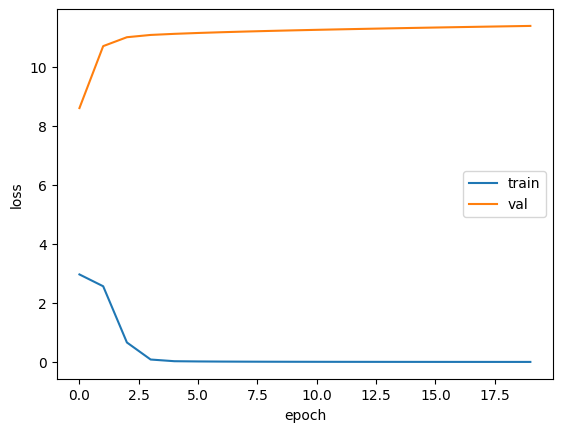

In [ ]:
plt.plot(med_train_losses,label='train')
plt.plot(med_val_losses,label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
plt.show()

In [ ]:
def predict_next_word(model, input_words, idx, vocab, context_len=5, device='cuda', sampling=True, temperature=1.0):
    model.eval()
    with torch.no_grad():
        input_indices = [idx.get(word.lower(), idx["<UNK>"]) for word in input_words]
        if len(input_indices) < context_len:
            padding = [idx["<PAD>"]] * (context_len - len(input_indices))
            input_indices = padding + input_indices
        elif len(input_indices) > context_len:
            input_indices = input_indices[-context_len:]

        input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)

        logits = model(input_tensor)

        if sampling:
            #apply softmax and sample
            probabilities = F.softmax(logits / temperature, dim=1)
            predicted_index = torch.multinomial(probabilities, 1).item()
        else:
            #use argmax, be greeedy
            predicted_index = torch.argmax(logits, dim=1).item()

        predicted_word = vocab[predicted_index]

    return predicted_word,probabilities

In [ ]:
#Example usage of predict_next_word
input_words = ["to", "be", "or", "not", "to"] #to be or not to be
predicted_word,proba = predict_next_word(med_ep_model, input_words, idx, vocab)
print(f"Input words: {' '.join(input_words)}")
print(f"Predicted next word: {predicted_word}")

Input words: to be or not to
Predicted next word: freshnew


In [ ]:
max(proba[0])

tensor(0.0032, device='cuda:0')

In [ ]:
torch.save(med_ep_model, 'next_word_mlp_med.pth')
print("Model weights saved to next_word_mlp_med.pth")

Model weights saved to next_word_mlp_med.pth


Low epoch model

In [ ]:
low_ep_model=NextWordMLP(len(vocab))

In [ ]:
low_ep_model,low_train_losses,low_val_losses=train_model(low_ep_model,X,y,epochs=5)

Made tensor dataset
Loaded in loader
Started Training
Epoch 1/5 train_loss=10.5131295737206827 val_loss=10.5700
Epoch 2/5 train_loss=7.7895909758025343 val_loss=10.8119
Epoch 3/5 train_loss=4.4049395405391625 val_loss=11.0960
Epoch 4/5 train_loss=1.1188006332712805 val_loss=11.3334
Epoch 5/5 train_loss=0.1017508192330762 val_loss=11.3885


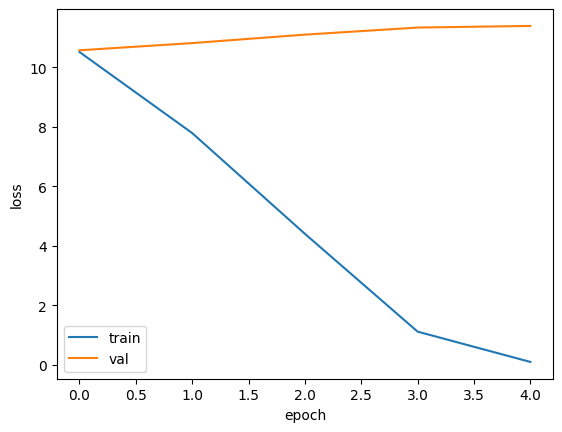

In [ ]:
plt.plot(low_train_losses,label='train')
plt.plot(low_val_losses,label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
plt.show()

In [ ]:
torch.save(low_ep_model, 'next_word_mlp_low.pth')
print("Model weights saved to next_word_mlp_low.pth")

Model weights saved to next_word_mlp_low.pth


In [ ]:
#Example usage of predict_next_word
input_words = ["to", "be", "or", "not", "to"] #to be or not to be
predicted_word_low,proba_low = predict_next_word(low_ep_model, input_words, idx, vocab)
print(f"Input words: {' '.join(input_words)}")
print(f"Predicted next word: {predicted_word_low}")

Input words: to be or not to
Predicted next word: outwardsainted


High epoch model

In [ ]:
high_ep_model=NextWordMLP(len(vocab))

In [ ]:
high_ep_model,high_train_losses,high_val_losses=train_model(high_ep_model,X,y,epochs=40)

Made tensor dataset
Loaded in loader
Started Training
Epoch 1/40 train_loss=1.2323772706744860 val_loss=2.0232
Epoch 2/40 train_loss=2.7450168438006139 val_loss=9.7223
Epoch 3/40 train_loss=0.7490629213799337 val_loss=10.7302
Epoch 4/40 train_loss=0.0564514152285946 val_loss=10.8560
Epoch 5/40 train_loss=0.0170081598596418 val_loss=10.9021
Epoch 6/40 train_loss=0.0120003325205747 val_loss=10.9386
Epoch 7/40 train_loss=0.0090227308789396 val_loss=10.9703
Epoch 8/40 train_loss=0.0070371615086629 val_loss=10.9987
Epoch 9/40 train_loss=0.0056479813238503 val_loss=11.0247
Epoch 10/40 train_loss=0.0046217547755533 val_loss=11.0488
Epoch 11/40 train_loss=0.0038367289014906 val_loss=11.0713
Epoch 12/40 train_loss=0.0032196002143634 val_loss=11.0925
Epoch 13/40 train_loss=0.0027249802613613 val_loss=11.1127
Epoch 14/40 train_loss=0.0023228310612645 val_loss=11.1320
Epoch 15/40 train_loss=0.0019917954873544 val_loss=11.1506
Epoch 16/40 train_loss=0.0017161437218526 val_loss=11.1685
Epoch 17/40 t

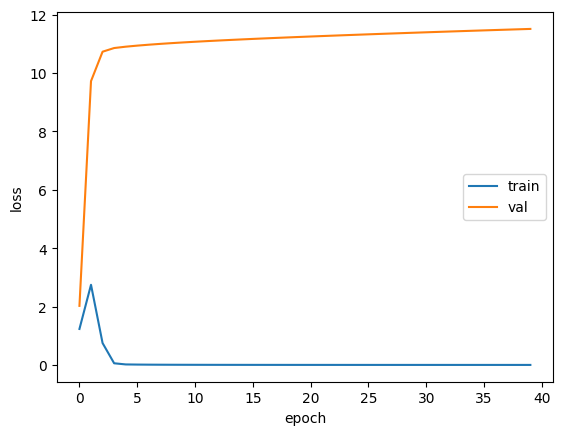

In [ ]:
plt.plot(high_train_losses,label='train')
plt.plot(high_val_losses,label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
plt.show()

It is overfitting

In [ ]:
torch.save(high_ep_model, 'next_word_mlp_high.pth')
print("Model weights saved to next_word_mlp_high.pth")

Model weights saved to next_word_mlp_high.pth


In [ ]:
#Example usage of predict_next_word
input_words = ["to", "be", "or", "not", "to"] #to be or not to be
predicted_word_high,proba_high = predict_next_word(high_ep_model, input_words, idx, vocab)
print(f"Input words: {' '.join(input_words)}")
print(f"Predicted next word: {predicted_word_high}")

Input words: to be or not to
Predicted next word: wept.


LOADING THE MODELS

In [ ]:
loaded_mlp=NextWordMLP(len(vocab))

In [ ]:
loaded_mlp=torch.load('next_word_mlp_med.pth',weights_only=False)

In [ ]:
input_words = ["to", "be", "or", "not", "to"] # Replace with your desired input words
predicted_word_loaded,proba_loaded = predict_next_word(loaded_mlp,input_words, idx, vocab)
print(f"Input words: {' '.join(input_words)}")
print(f"Predicted next word: {predicted_word_loaded}")

Input words: to be or not to
Predicted next word: naturally


Would ebe useful for streamlit app

CODE BASED TEXXT

In [ ]:
def preprocess_code_line(line):
    line = line.rstrip("\n")  #remove newline only
    #remove tabs but KEEP punctuation & operators
    line = line.replace("\t", " ")
    #collapse extra spaces
    line = re.sub(' +', ' ', line)
    return line.lower()

def build_vocab_from_code(lines, min_freq=1):
    words = []
    for ln in lines:
        ln = preprocess_code_line(ln)
        tokens = ln.split(" ")  #split by space
        words.extend(tokens)

    counts = Counter(words)

    vocab = ["<PAD>", "<UNK>"] + [w for w,c in counts.items() if c >= min_freq]
    idx = {w:i for i,w in enumerate(vocab)}
    return vocab, idx, counts


In [ ]:
with open('code.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

vocab_code, idx_code, counts_code = build_vocab_from_code(lines)

print("Code Vocab Size:", len(vocab_code))
print("10 Most Frequent:", counts_code.most_common(10))
print("10 Least Frequent:", sorted(counts_code, key=lambda x:counts_code[x])[:10])


Code Vocab Size: 111121
10 Most Frequent: [('', 194281), ('*', 33504), ('=', 28003), ('if', 18989), ('{', 18915), ('the', 17488), ('}', 16965), ('*/', 13445), ('/*', 12190), ('struct', 10997)]
10 Least Frequent: ['linux/kernel/irq/autoprobe.c', 'apis.', '"irqs_waiting"', 'define_mutex(probing_active);', 'probe_irq_on', 'commence', 'probe_irq_on(void)', 'mutex_lock(&probing_active);', '(desc->irq_data.chip->irq_set_type)', 'desc->irq_data.chip->irq_set_type(&desc->irq_data,']


In [ ]:
inde_cpp=tokens_to_indices(vocab_code,idx_code)
X_code,y_code=build_dataset(vocab_code,idx_code)

In [ ]:
print(X_code.shape,y_code.shape)

(111116, 5) (111116,)


In [ ]:
X_code[1]

array([1, 2, 3, 4, 5])

In [ ]:
code_model=NextWordMLP(len(vocab_code))

In [ ]:
code_model

NextWordMLP(
  (emb): Embedding(111121, 64)
  (ffn): Sequential(
    (0): Linear(in_features=320, out_features=111121, bias=True)
  )
)

In [ ]:
code_model_high,code_high_train_losses,code_high_val_losses=train_model(code_model,X_code,y_code)

Made tensor dataset
Loaded in loader
Started Training
Epoch 1/20 train_loss=7.2317407710070274 val_loss=12.1138
Epoch 2/20 train_loss=5.9757429932077004 val_loss=12.8140
Epoch 3/20 train_loss=0.8752168748213180 val_loss=13.1088
Epoch 4/20 train_loss=0.0151213041479095 val_loss=13.1452
Epoch 5/20 train_loss=0.0093423306741389 val_loss=13.1753
Epoch 6/20 train_loss=0.0062854868053241 val_loss=13.2055
Epoch 7/20 train_loss=0.0043356055004774 val_loss=13.2366
Epoch 8/20 train_loss=0.0030209841904754 val_loss=13.2687
Epoch 9/20 train_loss=0.0021097314827223 val_loss=13.3019
Epoch 10/20 train_loss=0.0014702785745287 val_loss=13.3361
Epoch 11/20 train_loss=0.0010204515148515 val_loss=13.3711
Epoch 12/20 train_loss=0.0007045271350623 val_loss=13.4069
Epoch 13/20 train_loss=0.0004839520020495 val_loss=13.4431
Epoch 14/20 train_loss=0.0003309907390742 val_loss=13.4795
Epoch 15/20 train_loss=0.0002256406440746 val_loss=13.5160
Epoch 16/20 train_loss=0.0001535701061752 val_loss=13.5523
Epoch 17/20

Pretty big dataset/



In [ ]:
#Example usage of predict_next_word for code
input_code_tokens = ["def", "preprocess_code_line", "("] #def ones
predicted_code_high,proba_code_med= predict_next_word(code_model_high, input_code_tokens, idx_code, vocab_code)
print(f"Input code tokens: {' '.join(input_code_tokens)}")
print(f"Predicted next token: {predicted_code_high}")

NameError: name 'predict_next_word' is not defined

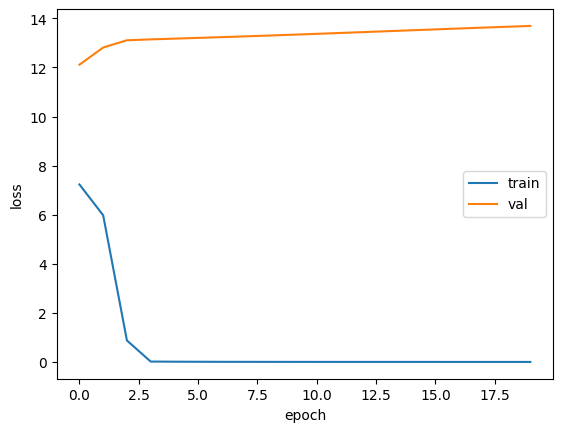

In [ ]:
plt.plot(code_high_train_losses,label='train')
plt.plot(code_high_val_losses,label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
plt.show()

In [ ]:
torch.save(code_model_med, 'next_word_mlp_code_high.pth')
print("Model weights saved to next_word_mlp_code_high.pth")

Model weights saved to next_word_mlp_code_high.pth


In [ ]:
code_model_low=NextWordMLP(len(vocab_code))
code_model_low,code_low_train_losses,code_low_val_losses=train_model(code_model_low,X_code,y_code,epochs=5)

Made tensor dataset
Loaded in loader
Started Training
Epoch 1/5 train_loss=11.7780377979296684 val_loss=12.0103
Epoch 2/5 train_loss=7.3583930662885724 val_loss=12.6763
Epoch 3/5 train_loss=1.7303107624464968 val_loss=13.2789
Epoch 4/5 train_loss=0.0186101867892263 val_loss=13.3117
Epoch 5/5 train_loss=0.0107999644421265 val_loss=13.3351


In [ ]:
#Example usage of predict_next_word for code
input_code_tokens = ["def", "preprocess_code_line", "("] #def ones
predicted_code_low,proba_code_low= predict_next_word(code_model_low, input_code_tokens, idx_code, vocab_code)
print(f"Input code tokens: {' '.join(input_code_tokens)}")
print(f"Predicted next token: {predicted_code_low}")

Input code tokens: def preprocess_code_line (
Predicted next token: lock_release_holdtime(struct


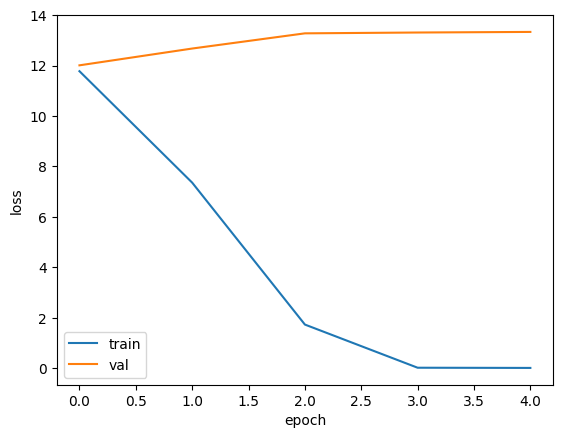

In [ ]:
plt.plot(code_low_train_losses,label='train')
plt.plot(code_low_val_losses,label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
plt.show()

In [ ]:
torch.save(code_model_low, 'next_word_mlp_code_low.pth')
print("Model weights saved to next_word_mlp_code_low.pth")

Model weights saved to next_word_mlp_code_low.pth


In [ ]:
code_model_med=NextWordMLP(len(vocab_code))
code_model_med,code_med_train_losses,code_med_val_losses=train_model(code_model_med, X_code, y_code,epochs=10)

Made tensor dataset
Loaded in loader
Started Training
Epoch 1/10 train_loss=11.7787815649004841 val_loss=12.0097
Epoch 2/10 train_loss=7.3594230480774847 val_loss=12.6754
Epoch 3/10 train_loss=1.7307393722859366 val_loss=13.2796
Epoch 4/10 train_loss=0.0186768159021636 val_loss=13.3119
Epoch 5/10 train_loss=0.0107884857680655 val_loss=13.3351
Epoch 6/10 train_loss=0.0078871677406935 val_loss=13.3607
Epoch 7/10 train_loss=0.0057896780250760 val_loss=13.3890
Epoch 8/10 train_loss=0.0042147611795526 val_loss=13.4199
Epoch 9/10 train_loss=0.0030295435689978 val_loss=13.4532
Epoch 10/10 train_loss=0.0021477672137164 val_loss=13.4884


In [ ]:
#Example usage of predict_next_word for code
input_code_tokens = ["def", "preprocess_code_line", "("] #def ones
predicted_code_med,proba_code_med= predict_next_word(code_model_med, input_code_tokens, idx_code, vocab_code)
print(f"Input code tokens: {' '.join(input_code_tokens)}")
print(f"Predicted next token: {predicted_code_med}")

Input code tokens: def preprocess_code_line (
Predicted next token: evaluated


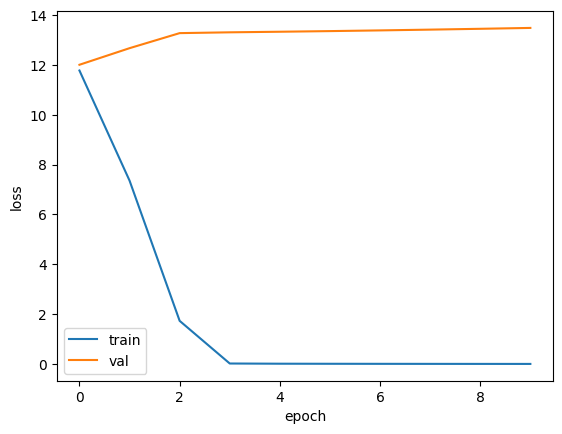

In [ ]:
plt.plot(code_med_train_losses,label='train')
plt.plot(code_med_val_losses,label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
plt.show()

In [ ]:
torch.save(code_model_med, 'next_word_mlp_code_med.pth')
print("Model weights saved to next_word_mlp_code_med.pth")

Model weights saved to next_word_mlp_code_med.pth


Saving the dicts and indexes for streamlit app

In [ ]:
import json

#downlaoding dicts for streamlit app
vocab = [str(w) for w in vocab]
idx = {str(k): int(v) for k, v in idx.items()}

with open("vocab.json", "w") as f:
    json.dump(vocab, f)

with open("idx.json", "w") as f:
    json.dump(idx, f)


#downloading  dicts for streamlit app
vocab_code = [str(w) for w in vocab_code]
idx_code = {str(k): int(v) for k, v in idx_code.items()}

with open("vocab_code.json", "w") as f:
    json.dump(vocab_code, f)

with open("idx_code.json", "w") as f:
    json.dump(idx_code, f)

